Simulating an Airplane in 2d
state x is [x_pos, z_pos, velocity, and upsilon (flight path angle, angle between earth frame and velocity frame )] ^T
input is [Thrust T, alpha (angel of attack, angel between body frame and velocity frame)]^T

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import fsolve
import yaml


In [2]:
def find_steady_straight_flight(earth_to_wind_angle, V_magnitude):

    with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)
    g = params['environmental']['gravity']
    mass = params['physical']['mass']   

    def equations(vars):
        u, w, theta, alpha, elevator = vars
        
        C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
                params['long_coef']['C_L_elevator'] * elevator
            
        C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
            params['long_coef']['C_D_elevator'] * elevator
    
        L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
        D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D

        C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
                params['long_coef']['C_M_moment_elevator'] * elevator
        w_dot = g*np.cos(theta) - D*np.sin(alpha)/mass - L*np.cos(alpha)/mass
        alpha_zero = alpha - np.arctan2(w,u)
        V_magnitude_zero = V_magnitude - np.sqrt(u**2 + w**2)
        earth_to_wind_angle_zero = earth_to_wind_angle - (theta-alpha)

        return [C_M_moment, w_dot, alpha_zero, V_magnitude_zero, earth_to_wind_angle_zero]
    
    u, w, theta, alpha, elevator = fsolve(equations, (1, 1, earth_to_wind_angle, 0, 0))

    # now solve for T
    V_magnitude = np.sqrt(u**2 + w**2)
    C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
            params['long_coef']['C_L_elevator'] * elevator
            
    C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
        params['long_coef']['C_D_elevator'] * elevator

    L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
    D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D

    T = g*np.sin(theta)*mass + D*np.cos(alpha) -L*np.sin(alpha)
            
    return(u, w, theta, alpha, elevator, T)

In [3]:
def find_steady_turn(psi_dot):
    with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)
    g = params['environmental']['gravity']
    mass = params['physical']['mass'] 
    Ixx = params['physical']['Ixx']
    Iyy = params['physical']['Iyy']
    Izz = params['physical']['Izz']
    Ixz = params['physical']['Ixz']
    
    alpha = 0
    beta = 0
    theta = 0
    p = 0
    v = 0
    w = 0

    def equations(vars):
        phi, u, r, q, elevator, aileron, rudder = vars
        V_magnitude = u

        C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
            params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_L_elevator'] * elevator
        
        C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
            params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_D_elevator'] * elevator
        
        C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
            params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_M_moment_elevator'] * elevator
        
    
        L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
        D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
        M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['c_wing_chord'] * C_M_moment
        

        C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
            params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_y_aileron'] * aileron + params['lat_coef']['C_y_rudder'] * rudder
        
        C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
            params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_L_moment_aileron'] * aileron + params['lat_coef']['C_L_moment_rudder'] * rudder
        
        C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
            params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_N_moment_aileron'] * aileron + params['lat_coef']['C_N_moment_rudder'] * rudder

        F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
        L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
                    * params['physical']['b_wing_span'] * C_L_moment
        N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['b_wing_span'] * C_N_moment
        
        # 7 equations
        phi_dot = q*np.cos(phi) - r*np.sin(phi)
        psi_dot_zero = psi_dot - (q*np.sin(phi)+r*np.cos(phi))
        v_dot = g*np.cos(theta)*np.sin(phi) - D*np.sin(beta)/mass + F_y/mass -r*u+p*w
        w_dot = g*np.cos(theta)*np.cos(phi) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q*u
        p_dot = ( -q*r*(Izz-Iyy) + N_moment*Ixz/Izz - p*q*Ixz*(Iyy-Ixx)/Izz - q*r*Ixz*Ixz/Izz +p*q*Ixz + L_moment)\
                                / (Ixx - Ixz*Ixz/Izz)
        
        q_dot = ( M_moment + p*r*(Izz-Ixx)-(p**2 - r**2)*Ixz ) / Iyy

        r_dot = ( -p*q*(Iyy-Ixx) - q*r*Ixz + L_moment*Ixz/Ixx - q*r*Ixz*(Izz-Iyy)/Ixx + p*q*Ixz*Ixz/Ixx + N_moment)\
                                / (Izz - Ixz*Ixz/Ixx)
        
        
        return[phi_dot, psi_dot_zero, v_dot, w_dot, p_dot, q_dot, r_dot]

    
    phi, u, r, q, elevator, aileron, rudder = fsolve(equations, (np.pi/4, 100, 0, 0, 0, 0, 0), maxfev=70000)

    # now solve for T    
    V_magnitude = u
    C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
        params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
        params['long_coef']['C_D_elevator'] * elevator

    D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D     

    T = D

    return phi, u, r, q, T, elevator, aileron, rudder

    

In [4]:
def find_steady_turn_radius(radius):
    with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)
    g = params['environmental']['gravity']
    mass = params['physical']['mass'] 
    Ixx = params['physical']['Ixx']
    Iyy = params['physical']['Iyy']
    Izz = params['physical']['Izz']
    Ixz = params['physical']['Ixz']
    
    alpha = 0
    beta = 0
    theta = 0
    p = 0
    v = 0
    w = 0

    def equations(vars):
        phi, psi_dot, u, r, q, elevator, aileron, rudder = vars
        V_magnitude = u

        C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
            params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_L_elevator'] * elevator
        
        C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
            params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_D_elevator'] * elevator
        
        C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
            params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
            params['long_coef']['C_M_moment_elevator'] * elevator
        
    
        L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
        D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
        M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['c_wing_chord'] * C_M_moment
        

        C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
            params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_y_aileron'] * aileron + params['lat_coef']['C_y_rudder'] * rudder
        
        C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
            params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_L_moment_aileron'] * aileron + params['lat_coef']['C_L_moment_rudder'] * rudder
        
        C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
            params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
            params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r +\
            params['lat_coef']['C_N_moment_aileron'] * aileron + params['lat_coef']['C_N_moment_rudder'] * rudder

        F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
        L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
                    * params['physical']['b_wing_span'] * C_L_moment
        N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
                    * params['physical']['b_wing_span'] * C_N_moment
        
        # 8 equations
        phi_dot = q*np.cos(phi) - r*np.sin(phi)
        psi_dot_zero = psi_dot - (q*np.sin(phi)+r*np.cos(phi))
        v_dot = g*np.cos(theta)*np.sin(phi) - D*np.sin(beta)/mass + F_y/mass -r*u+p*w
        w_dot = g*np.cos(theta)*np.cos(phi) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q*u
        p_dot = ( -q*r*(Izz-Iyy) + N_moment*Ixz/Izz - p*q*Ixz*(Iyy-Ixx)/Izz - q*r*Ixz*Ixz/Izz +p*q*Ixz + L_moment)\
                                / (Ixx - Ixz*Ixz/Izz)
        
        q_dot = ( M_moment + p*r*(Izz-Ixx)-(p**2 - r**2)*Ixz ) / Iyy

        r_dot = ( -p*q*(Iyy-Ixx) - q*r*Ixz + L_moment*Ixz/Ixx - q*r*Ixz*(Izz-Iyy)/Ixx + p*q*Ixz*Ixz/Ixx + N_moment)\
                                / (Izz - Ixz*Ixz/Ixx)
        radius_zero = radius - u/psi_dot
        
        
        return[phi_dot, psi_dot_zero, v_dot, w_dot, p_dot, q_dot, r_dot, radius_zero]

    
    phi, psi_dot, u, r, q, elevator, aileron, rudder = fsolve(equations, (np.pi/4, np.pi/32, 100, 0, 0, 0, 0, 0), maxfev=70000)

    # now solve for T    
    V_magnitude = u
    C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
        params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q +\
        params['long_coef']['C_D_elevator'] * elevator

    D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D     

    T = D

    return phi, psi_dot, u, r, q, T, elevator, aileron, rudder

In [5]:
# Thrust_init=0
# elevator_init=0
# aileron_init=0
# rudder_init=0
# u_init = 0
# w_init = 0
# phi_init = 0
# theta_init = 0
# r_init=0
# q_init = 0

# psi_dot = np.pi/16
# phi_init, u_init, r_init, q_init, Thrust_init, elevator_init, aileron_init, rudder_init = find_steady_turn(psi_dot)
# print(f"phi: {phi_init}, u_init: {u_init}, q,init:{q_init}, r_init:{r_init}, Thrust_init:{Thrust_init}"+\
#        f"elevator:{elevator_init}, aileon:{aileron_init}, rudder:{rudder_init}")

# # check results
# alpha = 0
# beta = 0
# theta = 0
# p = 0
# v = 0
# w = 0

# with open("aerosonde_parameters.yaml", 'r') as file:
#         params = yaml.safe_load(file)
# g = params['environmental']['gravity']
# mass = params['physical']['mass'] 
# Ixx = params['physical']['Ixx']
# Iyy = params['physical']['Iyy']
# Izz = params['physical']['Izz']
# Ixz = params['physical']['Ixz']
# V_magnitude = u_init


# C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
#     params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_L_elevator'] * elevator_init

# C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
#     params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_D_elevator'] * elevator_init

# C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
#     params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_M_moment_elevator'] * elevator_init


# L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
# D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
# M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['c_wing_chord'] * C_M_moment


# C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
#     params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_y_aileron'] * aileron_init + params['lat_coef']['C_y_rudder'] * rudder_init

# C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
#     params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_L_moment_aileron'] * aileron_init + params['lat_coef']['C_L_moment_rudder'] * rudder_init

# C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
#     params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_N_moment_aileron'] * aileron_init + params['lat_coef']['C_N_moment_rudder'] * rudder_init

# F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
# L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
#             * params['physical']['b_wing_span'] * C_L_moment
# N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['b_wing_span'] * C_N_moment

# psi_dot_zero = psi_dot - (q_init*np.sin(phi_init)+r_init*np.cos(phi_init))
# u_dot = -g*np.sin(theta) - D*np.cos(alpha)*np.cos(beta)/mass + L*np.sin(alpha)/mass + Thrust_init/mass -q_init*w+r_init*v
# v_dot = g*np.cos(theta)*np.sin(phi_init) - D*np.sin(beta)/mass + F_y/mass -r_init*u_init+p*w
# w_dot = g*np.cos(theta)*np.cos(phi_init) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q_init*u_init

# p_dot = ( -q_init*r_init*(Izz-Iyy) + N_moment*Ixz/Izz - p*q_init*Ixz*(Iyy-Ixx)/Izz - q_init*r_init*Ixz*Ixz/Izz +p*q_init*Ixz + L_moment)\
#                         / (Ixx - Ixz*Ixz/Izz)

# q_dot = ( M_moment + p*r_init*(Izz-Ixx)-(p**2 - r_init**2)*Ixz ) / Iyy

# r_dot = ( -p*q_init*(Iyy-Ixx) - q_init*r_init*Ixz + L_moment*Ixz/Ixx - q_init*r_init*Ixz*(Izz-Iyy)/Ixx + p*q_init*Ixz*Ixz/Ixx + N_moment)\
#                         / (Izz - Ixz*Ixz/Ixx)

# print(f"psi_dot_zero: {psi_dot_zero}, u_dot:{u_dot}, v_dot:{v_dot}, w_dot:{w_dot}, p_dot:{p_dot}, q_dot:{q_dot}, r_dot:{r_dot}")

In [6]:
# Thrust_init=0
# elevator_init=0
# aileron_init=0
# rudder_init=0
# u_init = 0
# w_init = 0
# phi_init = 0
# theta_init = 0
# r_init=0
# q_init = 0

# radius = 50
# phi_init, psi_dot_init, u_init, r_init, q_init, Thrust_init, elevator_init, aileron_init, rudder_init = find_steady_turn_radius(radius)
# print(f"phi: {phi_init}, u_init: {u_init}, q,init:{q_init}, r_init:{r_init}, Thrust_init:{Thrust_init}"+\
#        f"elevator:{elevator_init}, aileon:{aileron_init}, rudder:{rudder_init}")

# # check results
# alpha = 0
# beta = 0
# theta = 0
# p = 0
# v = 0
# w = 0

# with open("aerosonde_parameters.yaml", 'r') as file:
#         params = yaml.safe_load(file)
# g = params['environmental']['gravity']
# mass = params['physical']['mass'] 
# Ixx = params['physical']['Ixx']
# Iyy = params['physical']['Iyy']
# Izz = params['physical']['Izz']
# Ixz = params['physical']['Ixz']
# V_magnitude = u_init


# C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha + \
#     params['long_coef']['C_L_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_L_elevator'] * elevator_init

# C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha + \
#     params['long_coef']['C_D_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_D_elevator'] * elevator_init

# C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha + \
#     params['long_coef']['C_M_moment_q']*(params['physical']['c_wing_chord']/(2 *V_magnitude))*q_init +\
#     params['long_coef']['C_M_moment_elevator'] * elevator_init


# L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
# D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D
# M_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['c_wing_chord'] * C_M_moment


# C_y = params['lat_coef']['C_y_0'] + params['lat_coef']['C_y_beta'] * beta + \
#     params['lat_coef']['C_y_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_y_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_y_aileron'] * aileron_init + params['lat_coef']['C_y_rudder'] * rudder_init

# C_L_moment = params['lat_coef']['C_L_moment_0'] + params['lat_coef']['C_L_moment_beta'] * beta + \
#     params['lat_coef']['C_L_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_L_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_L_moment_aileron'] * aileron_init + params['lat_coef']['C_L_moment_rudder'] * rudder_init

# C_N_moment = params['lat_coef']['C_N_moment_0'] + params['lat_coef']['C_N_moment_beta'] * beta + \
#     params['lat_coef']['C_N_moment_p']*(params['physical']['b_wing_span']/(2 *V_magnitude))*p +\
#     params['lat_coef']['C_N_moment_r']*(params['physical']['b_wing_span']/(2 *V_magnitude))*r_init +\
#     params['lat_coef']['C_N_moment_aileron'] * aileron_init + params['lat_coef']['C_N_moment_rudder'] * rudder_init

# F_y = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_y
# L_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] \
#             * params['physical']['b_wing_span'] * C_L_moment
# N_moment = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings']\
#             * params['physical']['b_wing_span'] * C_N_moment

# psi_dot_zero = psi_dot_init - (q_init*np.sin(phi_init)+r_init*np.cos(phi_init))
# u_dot = -g*np.sin(theta) - D*np.cos(alpha)*np.cos(beta)/mass + L*np.sin(alpha)/mass + Thrust_init/mass -q_init*w+r_init*v
# v_dot = g*np.cos(theta)*np.sin(phi_init) - D*np.sin(beta)/mass + F_y/mass -r_init*u_init+p*w
# w_dot = g*np.cos(theta)*np.cos(phi_init) - D*np.sin(alpha)*np.cos(beta)/mass - L*np.cos(alpha)/mass -p*v+q_init*u_init

# p_dot = ( -q_init*r_init*(Izz-Iyy) + N_moment*Ixz/Izz - p*q_init*Ixz*(Iyy-Ixx)/Izz - q_init*r_init*Ixz*Ixz/Izz +p*q_init*Ixz + L_moment)\
#                         / (Ixx - Ixz*Ixz/Izz)

# q_dot = ( M_moment + p*r_init*(Izz-Ixx)-(p**2 - r_init**2)*Ixz ) / Iyy

# r_dot = ( -p*q_init*(Iyy-Ixx) - q_init*r_init*Ixz + L_moment*Ixz/Ixx - q_init*r_init*Ixz*(Izz-Iyy)/Ixx + p*q_init*Ixz*Ixz/Ixx + N_moment)\
#                         / (Izz - Ixz*Ixz/Ixx)

# print(f"psi_dot_zero: {psi_dot_zero}, u_dot:{u_dot}, v_dot:{v_dot}, w_dot:{w_dot}, p_dot:{p_dot}, q_dot:{q_dot}, r_dot:{r_dot}")

In [7]:
Thrust_init=0
elevator_init=0
aileron_init=0
rudder_init=0
x_init = 0
y_init = 0
z_init = 0
phi_init = 0
theta_init = 0
psi_init = 0
u_init = 0
v_init = 0
w_init = 0
p_init = 0
q_init = 0
r_init = 0

earth_to_wind_angle = np.pi/6
V_magnitude = 20

u_init, w_init, theta_init, alpha_init, elevator_init, Thrust_init = find_steady_straight_flight(earth_to_wind_angle, V_magnitude)
print(f"u: {u_init}, w: {w_init}, theta:{theta_init}, alpha:{alpha_init} elevator: {elevator_init}, T: {Thrust_init}")
print(f"sqrt(u^2 + w^2): {np.sqrt(u_init**2+w_init**2)}, theta - alpha:{theta_init-alpha_init}")


with open("aerosonde_parameters.yaml", 'r') as file:
        params = yaml.safe_load(file)

g = params['environmental']['gravity']
mass = params['physical']['mass']  

C_L = params['long_coef']['C_L_0'] + params['long_coef']['C_L_alpha'] * alpha_init + \
        params['long_coef']['C_L_elevator'] * elevator_init
        
C_D = params['long_coef']['C_D_0'] + params['long_coef']['C_D_alpha'] * alpha_init + \
    params['long_coef']['C_D_elevator'] * elevator_init

L = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_L
D = 0.5 * params['environmental']['rho_air_density'] * V_magnitude**2 * params['physical']['Surface_area_wings'] * C_D

C_M_moment = params['long_coef']['C_M_moment_0'] + params['long_coef']['C_M_moment_alpha'] * alpha_init + \
                params['long_coef']['C_M_moment_elevator'] * elevator_init

w_dot = g*np.cos(theta_init) - D*np.sin(alpha_init)/mass - L*np.cos(alpha_init)/mass
u_dot = -g*np.sin(theta_init) - D*np.cos(alpha_init)/mass + L*np.sin(alpha_init)/mass + Thrust_init/mass
print(f"C_M:{C_M_moment}, w_dot:{w_dot}, u_dot:{u_dot}")

u: 19.94056541007295, w: 1.540730713295502, theta:0.6007117126945082, alpha:0.0771129370962093 elevator: -0.19978732085213485, T: 60.061101190984544
sqrt(u^2 + w^2): 20.000000000107246, theta - alpha:0.5235987755982989
C_M:2.7755575615628914e-17, w_dot:1.7763568394002505e-15, u_dot:-8.908429549592256e-13


In [8]:
z_init = -100
psi_init = np.pi/4

Thrust_disturbance = 0
elevator_disturbance = 0
aileron_disturbance = 0
rudder_disturbance = 0

x_disturbance = 0
y_disturbance = 0
z_disturbance = 0
u_disturbance = 0#u_init/10
v_disturbance = 10
w_disturbance = 0#w_init/10
phi_disturbance = np.pi/8
theta_disturbance = 0#np.pi/16
psi_disturbance = 0
p_disturbance = np.pi/2
q_disturbance = 0#np.pi/2
r_disturbance = np.pi/2

# -np.pi/16 to aileon

input_init = np.array([[Thrust_init +Thrust_disturbance], [elevator_init + elevator_disturbance],[aileron_init+aileron_disturbance],[rudder_init+rudder_disturbance]])
state_init = np.array([[x_init + x_disturbance], [y_init + y_disturbance], [z_init + z_disturbance], 
                       [u_init + u_disturbance], [v_init + v_disturbance], [w_init + w_disturbance],
                       [phi_init + phi_disturbance], [theta_init + theta_disturbance], [psi_init + psi_disturbance], 
                       [p_init + p_disturbance], [q_init + q_disturbance], [r_init + r_disturbance]])


from airplane_3D_EOM import simulate_airplane
duration = 50
dt = 0.01
sol = simulate_airplane(state_init.squeeze(), input_init.squeeze(), duration, dt)


In [9]:
np.save("sol_nonlinear.npy", sol.y)
solution_data = np.load("sol_nonlinear.npy")
print(solution_data.shape)

(12, 5001)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


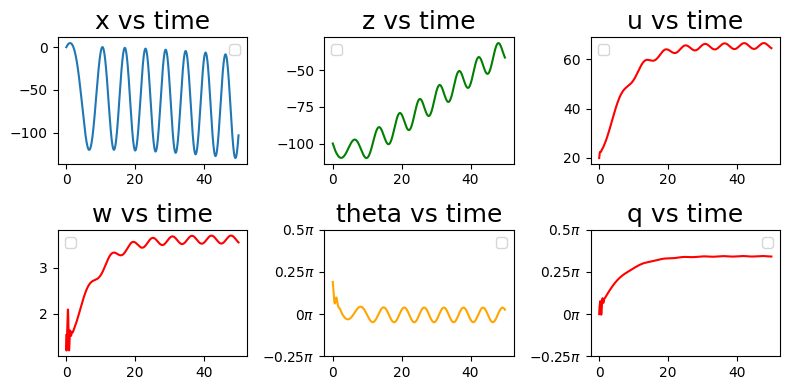

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


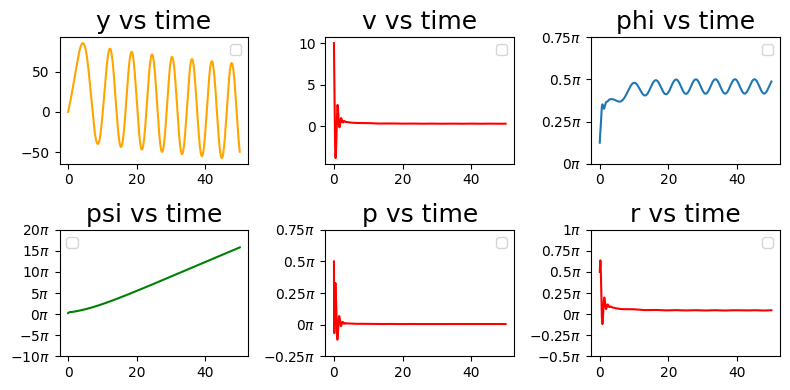

In [10]:
from airplane_plot import plot_airplane_data ,plot_airplane_long, plot_airplane_lat

plot_airplane_long(sol)
plot_airplane_lat(sol)

In [11]:
from airplane_3D_EOM_Linear import continuous_linearization, A_matrix_evalation

state_eq = np.array([[x_init], [y_init], [z_init], [u_init], [v_init], [w_init], 
                     [phi_init], [theta_init], [psi_init], [p_init], [q_init], [r_init]])

input_eq = np.array([[Thrust_init], [elevator_init],[aileron_init],[rudder_init]])

A_long4, B_long4, A_long6, B_long6, A_lat4, B_lat4, A_lat6, B_lat6 = continuous_linearization(state_eq.squeeze(), input_eq.squeeze())





continuous_eigenvalues: [-4.01027726+7.92357937j -4.01027726-7.92357937j  0.06099313+0.49901954j
  0.06099313-0.49901954j]
discrete_eigenvalues: [0.95767652+0.07604146j 0.95767652-0.07604146j 1.00059766+0.00499322j
 1.00059766-0.00499322j]
[-4.010277264717516, -4.010277264717516]
number of nonpositive real parts of eigenvalues: 2


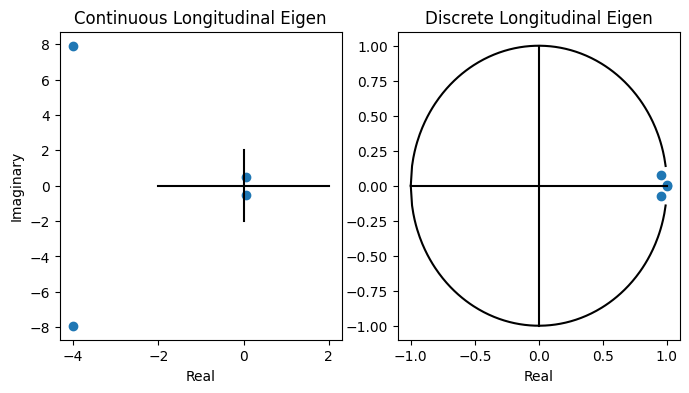

In [12]:
continuous_eig, discrete_eig = A_matrix_evalation(A_long4, dt)
print(f"continuous_eigenvalues: {continuous_eig}")
print(f"discrete_eigenvalues: {discrete_eig}")
x = [ele.real for ele in continuous_eig]
y = [ele.imag for ele in continuous_eig]

real_positive = [ele for ele in x if ele <= 0]
print(real_positive)
print(f"number of nonpositive real parts of eigenvalues: {len(real_positive)}")


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Continuous Longitudinal Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')


x = [ele.real for ele in discrete_eig]
y = [ele.imag for ele in discrete_eig]
plt.subplot(1,2,2)
plt.title("Discrete Longitudinal Eigen")
plt.scatter(x, y) 
plt.xlabel('Real') 
plt.plot(np.arange(-1,2,1), np.zeros(3), 'k')
plt.plot(np.zeros(3), np.arange(-1,2,1), 'k')
x_cir = np.arange(-1, 1, 0.01)
y_cir_positive = np.sqrt(1 - x_cir**2)
plt.plot(x_cir, y_cir_positive, 'k', x_cir, -y_cir_positive, 'k')
plt.show() 

In [13]:
# continuous_eig, discrete_eig = A_matrix_evalation(A_long6, dt)
# print(f"continuous_eigenvalues: {continuous_eig}")
# print(f"discrete_eigenvalues: {discrete_eig}")
# x = [ele.real for ele in continuous_eig]
# y = [ele.imag for ele in continuous_eig]

# plt.figure(figsize=(8,4))
# plt.subplot(1,2,1)
# plt.title("Continuous")
# plt.scatter(x, y) 
# plt.ylabel('Imaginary') 
# plt.xlabel('Real') 
# plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
# plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')


# x = [ele.real for ele in discrete_eig]
# y = [ele.imag for ele in discrete_eig]
# plt.subplot(1,2,2)
# plt.title("Discrete")
# plt.scatter(x, y) 
# plt.ylabel('Imaginary') 
# plt.xlabel('Real') 
# plt.plot(np.arange(-1,2,1), np.zeros(3), 'k')
# plt.plot(np.zeros(3), np.arange(-1,2,1), 'k')
# x_cir = np.arange(-1, 1, 0.01)
# y_cir_positive = np.sqrt(1 - x_cir**2)
# plt.plot(x_cir, y_cir_positive, 'k', x_cir, -y_cir_positive, 'k')
# plt.show() 

continuous_eigenvalues: [-14.2340075 +0.j          -2.16373425+6.20424585j
  -2.16373425-6.20424585j   0.29322565+0.j        ]
discrete_eigenvalues: [0.86732625+0.j        0.97671223+0.0606755j 0.97671223-0.0606755j
 1.00293656+0.j       ]
[-14.234007498489035, -2.163734252066666, -2.163734252066666]
number of nonpositive real parts of eigenvalues: 3


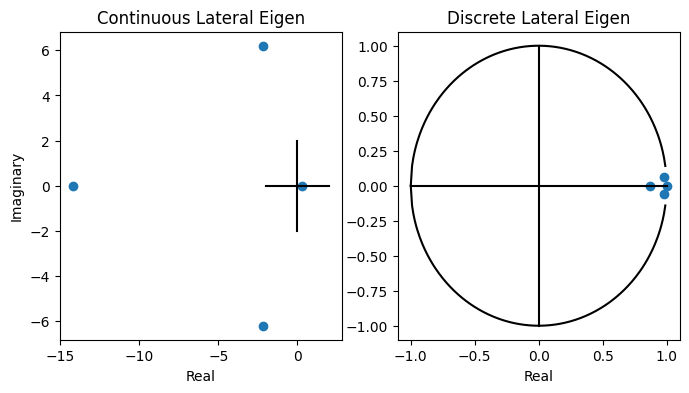

In [14]:
continuous_eig, discrete_eig = A_matrix_evalation(A_lat4, dt)
print(f"continuous_eigenvalues: {continuous_eig}")
print(f"discrete_eigenvalues: {discrete_eig}")
x = [ele.real for ele in continuous_eig]
y = [ele.imag for ele in continuous_eig]

real_positive = [ele for ele in x if ele <= 0]
print(real_positive)
print(f"number of nonpositive real parts of eigenvalues: {len(real_positive)}")


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Continuous Lateral Eigen")
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')


x = [ele.real for ele in discrete_eig]
y = [ele.imag for ele in discrete_eig]
plt.subplot(1,2,2)
plt.title("Discrete Lateral Eigen")
plt.scatter(x, y) 
plt.xlabel('Real') 
plt.plot(np.arange(-1,2,1), np.zeros(3), 'k')
plt.plot(np.zeros(3), np.arange(-1,2,1), 'k')
x_cir = np.arange(-1, 1, 0.01)
y_cir_positive = np.sqrt(1 - x_cir**2)
plt.plot(x_cir, y_cir_positive, 'k', x_cir, -y_cir_positive, 'k')
plt.show() 

In [15]:
# continuous_eig, discrete_eig = A_matrix_evalation(A_lat6, dt)
# print(f"continuous_eigenvalues: {continuous_eig}")
# print(f"discrete_eigenvalues: {discrete_eig}")
# x = [ele.real for ele in continuous_eig]
# y = [ele.imag for ele in continuous_eig]

# plt.figure(figsize=(8,4))
# plt.subplot(1,2,1)
# plt.title("Continuous")
# plt.scatter(x, y) 
# plt.ylabel('Imaginary') 
# plt.xlabel('Real') 
# plt.plot(np.arange(-2,3,1), np.zeros(5), 'k')
# plt.plot(np.zeros(5), np.arange(-2,3,1), 'k')


# x = [ele.real for ele in discrete_eig]
# y = [ele.imag for ele in discrete_eig]
# plt.subplot(1,2,2)
# plt.title("Discrete")
# plt.scatter(x, y) 
# plt.ylabel('Imaginary') 
# plt.xlabel('Real') 
# plt.plot(np.arange(-1,2,1), np.zeros(3), 'k')
# plt.plot(np.zeros(3), np.arange(-1,2,1), 'k')
# x_cir = np.arange(-1, 1, 0.01)
# y_cir_positive = np.sqrt(1 - x_cir**2)
# plt.plot(x_cir, y_cir_positive, 'k', x_cir, -y_cir_positive, 'k')
# plt.show() 

In [16]:
from airplane_3D_EOM_Linear import discrete_simulation

state_eq = np.array([[x_init], [y_init], [z_init], [u_init], [v_init], [w_init], 
                     [phi_init], [theta_init], [psi_init], [p_init], [q_init], [r_init]])

input_eq = np.array([[Thrust_init], [elevator_init],[aileron_init],[rudder_init]])


results = discrete_simulation(state_eq, input_eq, state_init, input_init, dt, duration)


In [17]:
print(results[:,0])
print(results[:,1])

[   0.            0.         -100.           19.94056541   10.
    1.54073071    0.39269908    0.60071171    0.78539816    1.57079633
    0.            1.57079633]
[   0.12247449    0.22247449 -100.1          19.94056541   19.69012391
    1.54073071    0.81186894    0.60071171    0.80443965    2.75890475
    0.            3.2136862 ]


In [18]:
np.save("sol_linear.npy", results)

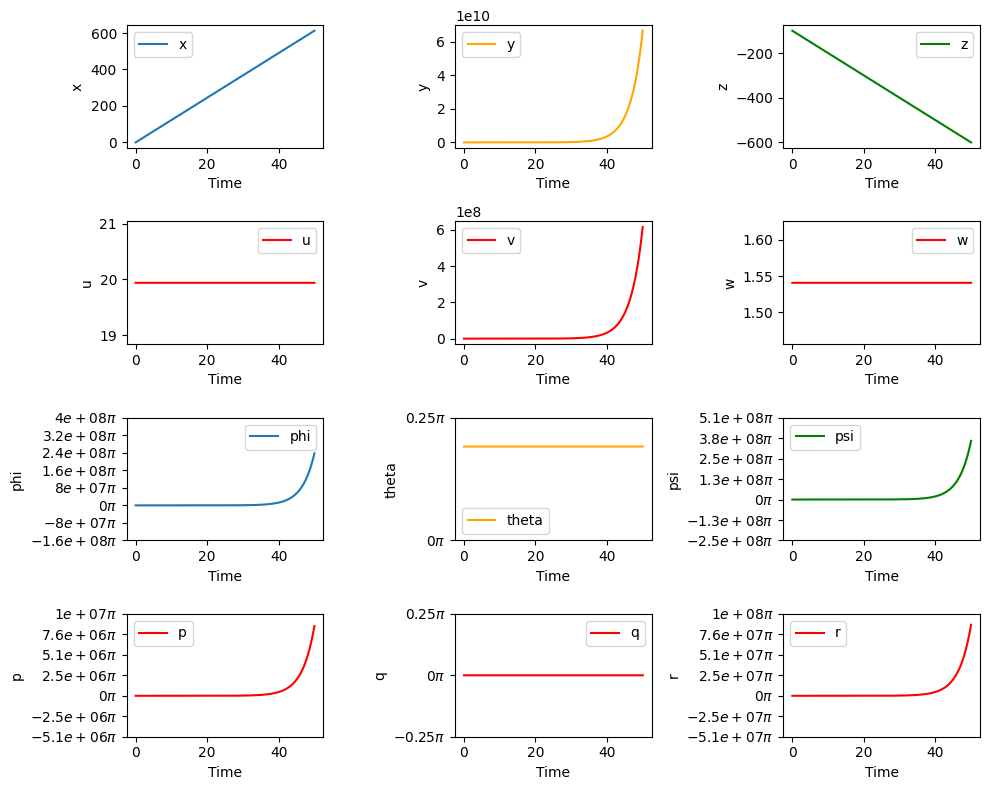

In [19]:
class solutions:
    pass

results_list = results.tolist()


sol_discrete = solutions()
sol_discrete.t = np.arange(0,duration+dt/2,dt).tolist()
sol_discrete.y = [None] * 12
sol_discrete.y[0] = results_list[0]
sol_discrete.y[1] = results_list[1]
sol_discrete.y[2] = results_list[2]
sol_discrete.y[3] = results_list[3]
sol_discrete.y[4] = results_list[4]
sol_discrete.y[5] = results_list[5]
sol_discrete.y[6] = results_list[6]
sol_discrete.y[7] = results_list[7]
sol_discrete.y[8] = results_list[8]
sol_discrete.y[9] = results_list[9]
sol_discrete.y[10] = results_list[10]
sol_discrete.y[11] = results_list[11]




from airplane_plot import plot_airplane_data

plot_airplane_data(sol_discrete)

In [20]:
# from airplane_3D_EOM_Linear import discrete_simulation2


# state_init = np.array([[x_init], [y_init], [z_init], [u_init], [v_init], [w_init],
#                    [phi_init], [theta_init], [psi_init], [p_init], [q_init], [r_init]])
# input_init = np.array([[Thrust], [elevator],[aileron],[rudder]])
# input_new = np.array([[Thrust+Thrust_disturbance], [elevator+elevator_disturbance],[aileron+aileron_disturbance],[rudder+rudder_disturbance]])

# results2 = discrete_simulation2(state_init, input_init, input_new, dt, duration)

In [21]:
# class solutions:
#     pass

# results_list2 = results2.tolist()


# sol_discrete2 = solutions()
# sol_discrete2.t = np.arange(0,duration+dt/2,dt).tolist()
# sol_discrete2.y = [None] * 12
# sol_discrete2.y[0] = results_list2[0]
# sol_discrete2.y[1] = results_list2[1]
# sol_discrete2.y[2] = results_list2[2]
# sol_discrete2.y[3] = results_list2[3]
# sol_discrete2.y[4] = results_list2[4]
# sol_discrete2.y[5] = results_list2[5]
# sol_discrete2.y[6] = results_list2[6]
# sol_discrete2.y[7] = results_list2[7]
# sol_discrete2.y[8] = results_list2[8]
# sol_discrete2.y[9] = results_list2[9]
# sol_discrete2.y[10] = results_list2[10]
# sol_discrete2.y[11] = results_list2[11]




# from airplane_plot import plot_airplane_data

# plot_airplane_data(sol_discrete2)

In [22]:
# class solutions:
#     pass


# error = solutions()
# error.t = np.arange(0,duration+dt/2,dt).tolist()
# error.y = [None] * 12
# error.y[0] = sol_discrete.y[0] - sol.y[0]
# error.y[1] = sol_discrete.y[1] - sol.y[1]
# error.y[2] = sol_discrete.y[2] - sol.y[2]
# error.y[3] = sol_discrete.y[3] - sol.y[3]
# error.y[4] = sol_discrete.y[4] - sol.y[4]
# error.y[5] = sol_discrete.y[5] - sol.y[5]
# error.y[6] = sol_discrete.y[6] - sol.y[6]
# error.y[7] = sol_discrete.y[7] - sol.y[7]
# error.y[8] = sol_discrete.y[8] - sol.y[8]
# error.y[9] = sol_discrete.y[9] - sol.y[9]
# error.y[10] =sol_discrete.y[10] - sol.y[10]
# error.y[11] = sol_discrete.y[11] - sol.y[11]

# from airplane_plot import plot_airplane_data

# plot_airplane_data(error)

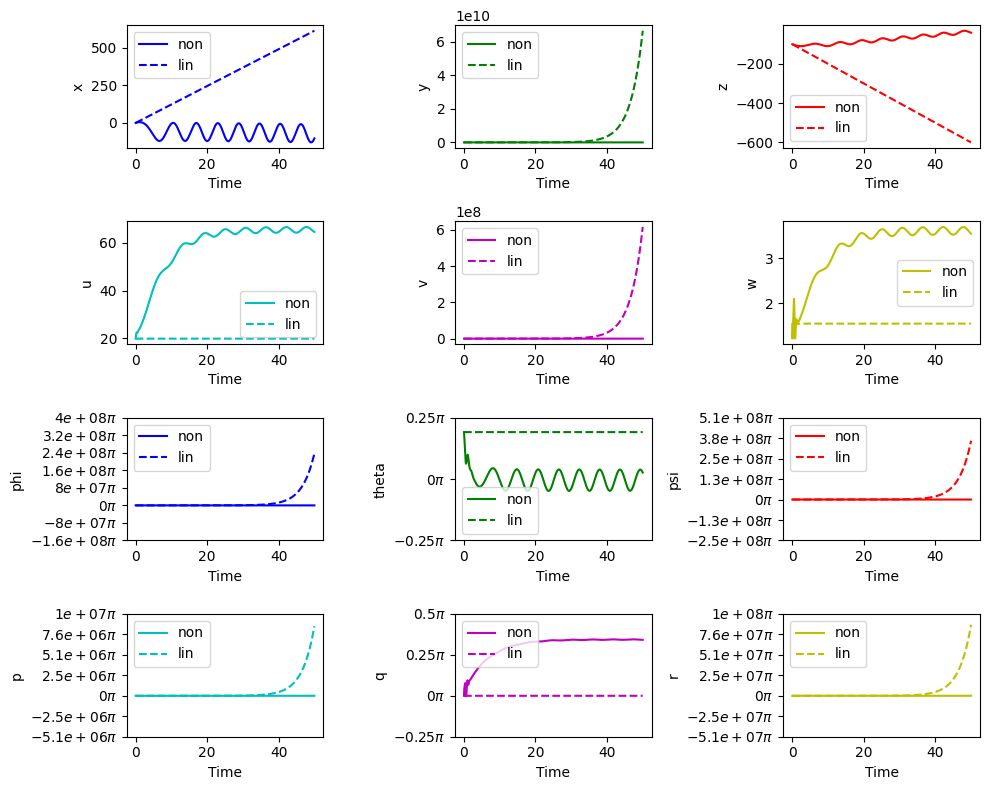

In [23]:
from airplane_plot import plot_airplane_compare_data

plot_airplane_compare_data(sol, sol_discrete)

In [24]:
# from airplane_plot import plot_airplane_compare_data

# plot_airplane_compare_data(sol, sol_discrete2)